## Node

In [4]:
class Node():
    def __init__(self, featureIndex=None, threshold=None, left=None, right=None, infoGain=None, value=None):
        self.featureIndex = featureIndex
        self.threshold = threshold 
        self.left = left 
        self.right = right 
        self.infoGain = infoGain
        self.value = value 


## Decision Tree Implementation

In [5]:

import pandas as pd
import numpy as np

class DecisionTree():
    def __init__(self, minSamples, maxDepth, class_names=None):
        self.minSamples = minSamples
        self.maxDepth = maxDepth
        self.root = None
        self.class_names = class_names

    def buildTree(self, dataset, currDepth=0):
        X, Y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        numSamples, numCols = dataset.shape
        numFeatures = numCols - 1
        
        if numSamples <= self.minSamples or currDepth >= self.maxDepth:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)
        
        bestSplit = self.getBestSplit(dataset=dataset, numSamples=numSamples, numFeatures=numFeatures)
        
        if not bestSplit or bestSplit.get("infoGain", 0) <= 0:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)
        
        left_subtree = self.buildTree(bestSplit["left"], currDepth + 1)
        right_subtree = self.buildTree(bestSplit["right"], currDepth + 1)
        return Node(featureIndex=bestSplit["featureIndex"], threshold=bestSplit["threshold"], 
                   left=left_subtree, right=right_subtree, infoGain=bestSplit["infoGain"])

    def getBestSplit(self, dataset, numSamples, numFeatures):
        max_IG = -float("inf")
        bestSplit = {}
        
        for featureIndex in range(numFeatures):
            featureSamples = dataset.iloc[:, featureIndex]
            uniqueThresholds = np.sort(np.unique(featureSamples))
            
            if len(uniqueThresholds) <= 1:
                continue
            
            possibleThresholds = (uniqueThresholds[:-1] + uniqueThresholds[1:]) / 2.0
            
            for threshold in possibleThresholds:
                leftDataset, rightDataset = self.split(dataset=dataset, featureIndex=featureIndex, threshold=threshold)
                
                if len(leftDataset) > 0 and len(rightDataset) > 0:
                    datasetTargets = dataset.iloc[:, -1]
                    leftTargets = leftDataset.iloc[:, -1]
                    rightTargets = rightDataset.iloc[:, -1]
                    datasetEntropy = self.entropy(datasetTargets)
                    leftDatasetEntropy = self.entropy(leftTargets)
                    rightDatasetEntropy = self.entropy(rightTargets)
                    IG = self.informationGain(datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, 
                                            datasetTargets, leftTargets, rightTargets)
                    
                    if IG > max_IG:
                        max_IG = IG
                        bestSplit["featureIndex"] = featureIndex
                        bestSplit["threshold"] = threshold
                        bestSplit["left"] = leftDataset
                        bestSplit["right"] = rightDataset
                        bestSplit["infoGain"] = IG
        
        return bestSplit

    def split(self, dataset, featureIndex, threshold):
        mask = np.array(dataset.iloc[:, featureIndex]) <= threshold
        leftDataset, rightDataset = dataset[mask], dataset[~mask]
        return leftDataset, rightDataset

    def entropy(self, dataset):
        datasetEntropy = 0.0
        numberOfExamples = len(dataset)
        classesLabels = np.unique(dataset)
        
        for cls in classesLabels:
            p = len(dataset[dataset == cls]) / numberOfExamples
            if p > 0:
                datasetEntropy = datasetEntropy - (p * np.log2(p))
        
        return datasetEntropy

    def informationGain(self, datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, 
                       datasetTargets, leftTargets, rightTargets):
        l_weight = len(leftTargets) / len(datasetTargets)
        r_weight = len(rightTargets) / len(datasetTargets)
        IG = datasetEntropy - (l_weight * leftDatasetEntropy + r_weight * rightDatasetEntropy)
        return IG

    def calcLeafValue(self, Y):
        classes, counts = np.unique(Y, return_counts=True)
        return classes[np.argmax(counts)]

    def fit(self, X, Y):
        dataset = pd.DataFrame(np.concatenate((X, Y), axis=1))
        self.root = self.buildTree(dataset)

    def predict(self, X):
        predictions = [self.makePrediction(x, self.root) for x in X]
        return np.array(predictions)

    def makePrediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        
        feature = x[tree.featureIndex]
        if feature <= tree.threshold:
            return self.makePrediction(x, tree.left)
        else:
            return self.makePrediction(x, tree.right)



## Random Forest Implementation

In [6]:

# Custom Random Forest Implementation (FIXED)
from collections import Counter

class RandomForest:
    def __init__(self, n_trees=10, max_features=None, max_depth=None, min_samples_split=2, 
                 class_names=None, random_state=None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_names = class_names
        self.trees = []
        self.random_state = random_state
        
        if random_state is not None:
            np.random.seed(random_state)

    def _bootstrap_sample(self, X, Y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], Y[indices]

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        else:
            return np.random.choice(n_features, self.max_features, replace=False)

    def fit(self, X, Y):
        self.trees = []
        n_features = X.shape[1]
        
        for i in range(self.n_trees):
            X_sample, Y_sample = self._bootstrap_sample(X, Y)
            feature_indices = self._get_feature_indices(n_features)
            
            tree = DecisionTree(
                minSamples=self.min_samples_split,
                maxDepth=self.max_depth,
                class_names=self.class_names
            )
            
            X_tree = X_sample[:, feature_indices]
            tree.fit(X_tree, Y_sample)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        tree_preds = []
        
        for tree, feature_indices in self.trees:
            X_sub = X[:, feature_indices]
            preds = tree.predict(X_sub)
            tree_preds.append(preds)
        
        tree_preds = np.array(tree_preds)
        y_pred = []
        
        for i in range(X.shape[0]):
            votes = tree_preds[:, i]
            # Convert to float to ensure consistent type
            votes = votes.astype(float).flatten()
            # Get most common vote
            vote = Counter(votes).most_common(1)[0][0]
            y_pred.append(vote)
        
        return np.array(y_pred)



## Load Data 
- breast_cancer dataset is used 

In [7]:
# EXAMPLE USAGE AND HYPERPARAMETER TUNING

from math import sqrt, floor
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Load data
data = load_breast_cancer()
X = data.data
Y = data.target.reshape(-1, 1)
feature_names = data.feature_names
class_names = list(data.target_names)

# 70/15/15 split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42, stratify=Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.1765, random_state=42, stratify=Y_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (397, 30), Val: (86, 30), Test: (86, 30)


## Hyperparameter Tuning 

In [8]:

# Hyperparameter grid
best_max_depth = 4
best_min_samples = 2

d = X.shape[1]
grid_T = [5, 10, 30, 50]
grid_max_features = [floor(sqrt(d)), floor(d/2)]

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

results = []
for T in grid_T:
    for max_feat in grid_max_features:
        rf = RandomForest(
            n_trees=T,
            max_features=max_feat,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples,
            random_state=42
        )
        
        rf.fit(X_train, Y_train)
        Y_val_pred = rf.predict(X_val)
        acc = accuracy_score(Y_val, Y_val_pred)
        
        results.append({
            'T': T,
            'max_features': max_feat,
            'val_accuracy': acc
        })
        print(f"T={T}, max_features={max_feat}: Val Accuracy={acc:.4f}")


HYPERPARAMETER TUNING
T=5, max_features=5: Val Accuracy=0.9651
T=5, max_features=15: Val Accuracy=0.9884
T=10, max_features=5: Val Accuracy=0.9419
T=10, max_features=15: Val Accuracy=0.9884
T=30, max_features=5: Val Accuracy=0.9535
T=30, max_features=15: Val Accuracy=0.9767
T=50, max_features=5: Val Accuracy=0.9767
T=50, max_features=15: Val Accuracy=0.9767


## Select best parameters

In [9]:
# Select best hyperparameters
results_df = pd.DataFrame(results)
best_idx = results_df['val_accuracy'].idxmax()
best_params = results_df.iloc[best_idx]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"T (n_trees): {int(best_params['T'])}")
print(f"max_features: {int(best_params['max_features'])}")
print(f"Validation Accuracy: {best_params['val_accuracy']:.4f}")



BEST HYPERPARAMETERS
T (n_trees): 5
max_features: 15
Validation Accuracy: 0.9884


## Hyperparameter Tuning Results

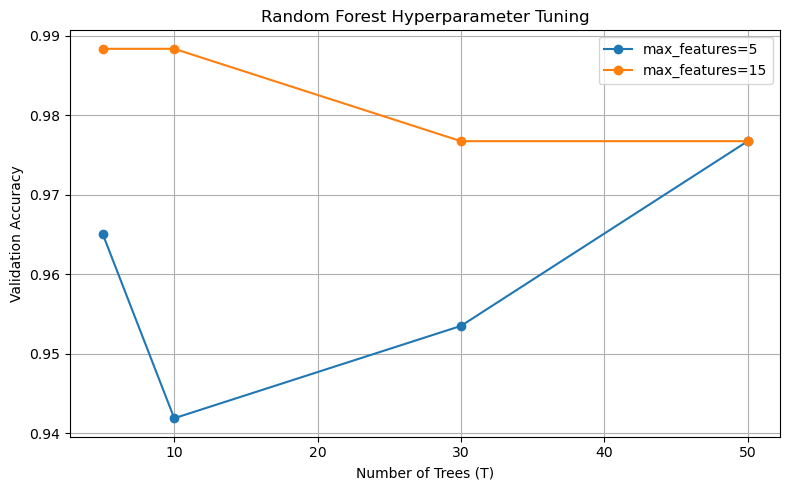

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
if 'results_df' in locals():
    plt.figure(figsize=(8,5))
    for max_feat in results_df['max_features'].unique():
        subset = results_df[results_df['max_features'] == max_feat]
        plt.plot(subset['T'], subset['val_accuracy'], marker='o', label=f'max_features={max_feat}')
    plt.xlabel('Number of Trees (T)')
    plt.ylabel('Validation Accuracy')
    plt.title('Random Forest Hyperparameter Tuning')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Retrain with best params

In [11]:

# Retrain on train+val with best params
rf_final = RandomForest(
    n_trees=int(best_params['T']),
    max_features=int(best_params['max_features']),
    max_depth=best_max_depth,
    min_samples_split=best_min_samples,
    random_state=42
)

X_trainval_combined = np.vstack([X_train, X_val])
Y_trainval_combined = np.vstack([Y_train, Y_val])

rf_final.fit(X_trainval_combined, Y_trainval_combined)


## Test predict

In [12]:

Y_test_pred = rf_final.predict(X_test)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

test_acc = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall = recall_score(Y_test, Y_test_pred, average='weighted')
f1 = f1_score(Y_test, Y_test_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(Y_test, Y_test_pred, target_names=class_names))

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = confusion_matrix(Y_test, Y_test_pred)
print(cm)


TEST SET PERFORMANCE

Test Accuracy: 0.9419
Precision (weighted): 0.9425
Recall (weighted): 0.9419
F1-Score (weighted): 0.9420

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   malignant       0.91      0.94      0.92        32
      benign       0.96      0.94      0.95        54

    accuracy                           0.94        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.94      0.94      0.94        86


CONFUSION MATRIX
[[30  2]
 [ 3 51]]


## Confusion Matrix

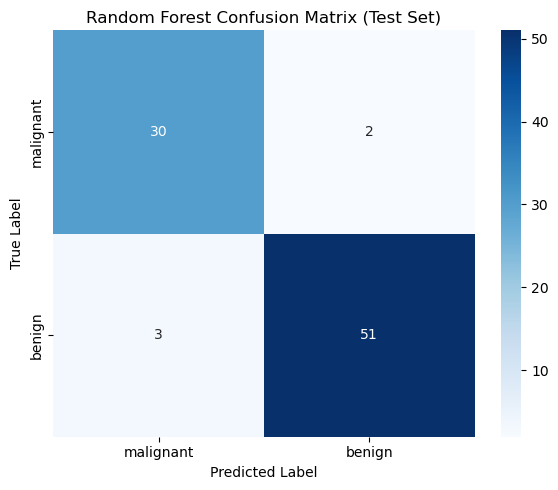

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()


## Feature Importances

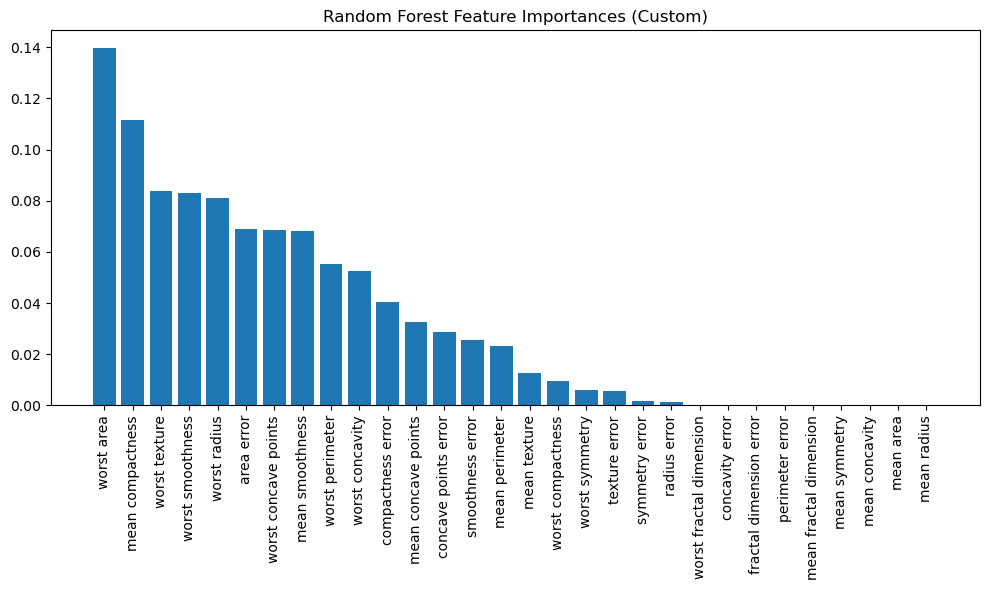

In [14]:

importances = np.zeros(X.shape[1])
for tree, feat_idx in rf_final.trees:
    if hasattr(tree, 'root'):
        def traverse(node, feat_map):
            if node is None or node.value is not None:
                return
            feat_map[feat_idx[node.featureIndex]] += node.infoGain if node.infoGain is not None else 0
            traverse(node.left, feat_map)
            traverse(node.right, feat_map)
        traverse(tree.root, importances)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title('Random Forest Feature Importances (Custom)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


## Training vs Validation Accuracy

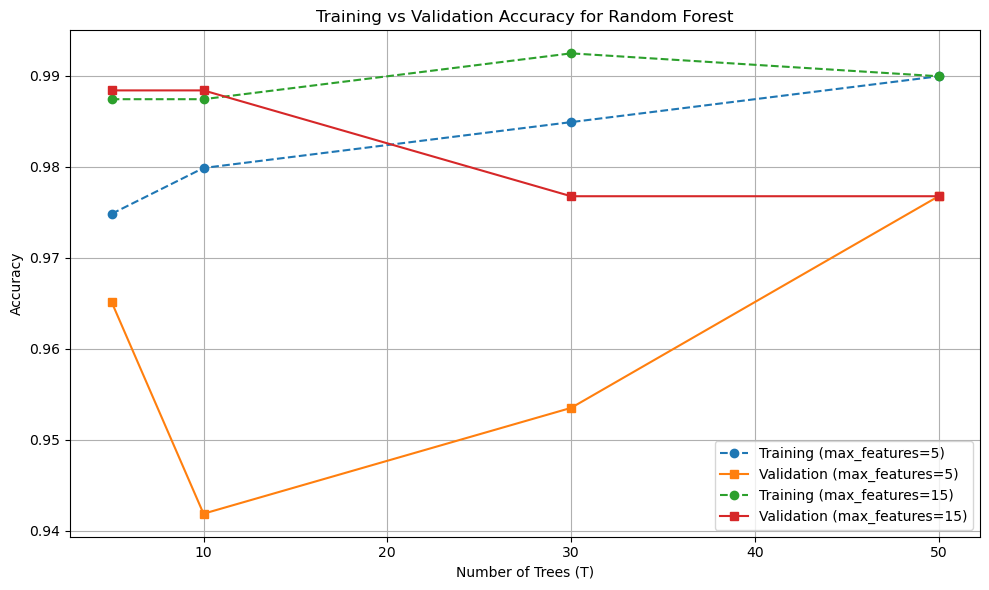

In [15]:

train_accuracies = []
val_accuracies = []
T_values = []
max_features_values = []

for T in grid_T:
    for max_feat in grid_max_features:
        rf = RandomForest(
            n_trees=T,
            max_features=max_feat,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples,
            random_state=42
        )
        rf.fit(X_train, Y_train)
        Y_train_pred = rf.predict(X_train)
        Y_val_pred = rf.predict(X_val)
        train_acc = accuracy_score(Y_train, Y_train_pred)
        val_acc = accuracy_score(Y_val, Y_val_pred)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        T_values.append(T)
        max_features_values.append(max_feat)

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
for max_feat in set(max_features_values):
    idxs = [i for i, mf in enumerate(max_features_values) if mf == max_feat]
    plt.plot(np.array(T_values)[idxs], np.array(train_accuracies)[idxs], marker='o', linestyle='--', label=f'Training (max_features={max_feat})')
    plt.plot(np.array(T_values)[idxs], np.array(val_accuracies)[idxs], marker='s', linestyle='-', label=f'Validation (max_features={max_feat})')
plt.xlabel('Number of Trees (T)')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()